In [12]:

import pandas as pd
import numpy as np
import newtonRaphson as NR
import matplotlib.pyplot as plt
import volatility_surface as VLS

daycount = 260

data =pd.read_csv("Data.csv")
data = data[data["Mispriced"]==False]
data.drop(["Mispriced"],axis = 1,inplace=True)
data["T"] = data["DaysToMat"]/daycount

spot = 1293.77
rf = 0.005
params={
    "spot":spot,
    "rf":rf,
    "data":data
}

def cumStdNorm(d):
    from math import erf,sqrt
    return (1.0+erf(d/sqrt(2.0)))/2.0
#
#---------------------------------------------------------------------------
def BlackScholePricingErr(x, marketCallPrice, strike, maturity, assetPrice, riskFree):
    from math import log,sqrt,exp
#
    d1=(log(assetPrice/strike)+(riskFree+0.5*x[0]**2)*maturity)/(x[0]*sqrt(maturity))
    d2=d1-x[0]*sqrt(maturity)  
    callPrice=assetPrice*cumStdNorm(d1)-strike*exp(-riskFree*maturity)*cumStdNorm(d2)  
    g=[callPrice-marketCallPrice]
#
    return g
# --------------------------------------------------------------------------
def plot_check(x:pd.DataFrame,y:pd.DataFrame,pos):
    plt.plot(x.iloc[:,pos])
    plt.plot(y.iloc[:,pos])

    plt.title("maturity: {0:2f} Year".format(y.columns[pos]))
    plt.xlabel("Price")
    plt.ylabel("Implied Volatility")
    plt.show
# --------------------------------------------------------------------------
out = pd.DataFrame(index = data.index, columns = ["EstImpVol", "PrecFlag", "MaxDev"])

for indexval in data.index:
    price = data.loc[indexval,"MarketPrice"]
    strike = data.loc[indexval,"Strike"]
    mat = data.loc[indexval,"T"]
    x, premet, maxdev = NR.newtonRaphson(lambda x : BlackScholePricingErr(x,price, strike, mat, spot, rf), [0.3], 1e-6)
    out.loc[indexval,:] = [x[0],premet,maxdev]

data["ImpVol"] = out["EstImpVol"]



In [13]:
X = VLS.gen_maturity_vol_func_dataset(data["Strike"],data["T"].values,params)
H = VLS.solve_maturity_vol_parms(X,data["ImpVol"])

print(H)


                X0        X1         X2          X3
0.007692  0.189215 -1.581103  22.714288  450.845212
0.030769  0.166362 -1.560704   4.079527  272.659256
0.092308  0.149405 -0.844823  -2.753637  101.232952
0.226923   0.14794 -0.559402  -1.537401   29.383167
0.334615    0.1407 -0.301027   1.034052    1.506265
0.380769  0.150437 -0.391081  -0.040011    5.904403
0.442308  0.149186 -0.369091   -0.09069    6.276655
0.684615  0.150989 -0.257783  -0.202466    2.850701
0.734615  0.153243 -0.266734  -0.250513    3.077028
1.034615  0.151727 -0.201289    0.01938    0.943947
1.084615  0.150976 -0.159325  -0.222308    1.237214
1.384615  0.148029 -0.163131  -0.262987     1.72567
1.734615  0.149226 -0.144991  -0.175323    0.894429
2.461538  0.144576 -0.126477   0.067941     0.18606
3.861538  0.146923 -0.080267  -0.117698    0.293429


100%|██████████| 360/360 [00:00<00:00, 468.47it/s]


0      0.013644
1     -0.012421
2      0.004214
3     -0.004435
4     -0.000279
         ...   
370   -0.000813
371   -0.000065
372    0.002567
373   -0.001065
374   -0.000289
Length: 360, dtype: object
Max Error= 0.017149180958581672, MSE = 1.477332755313979e-05


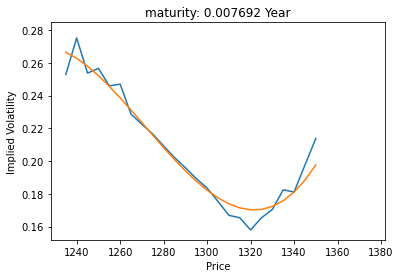

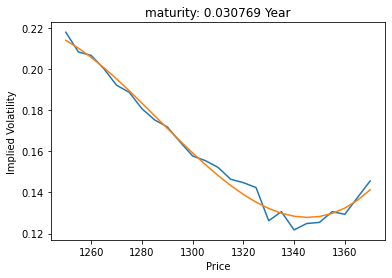

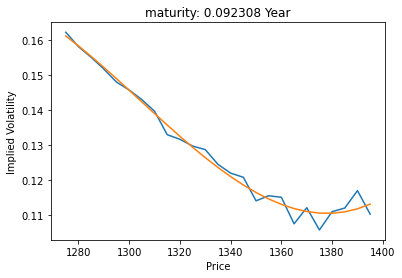

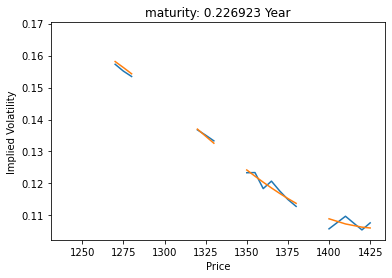

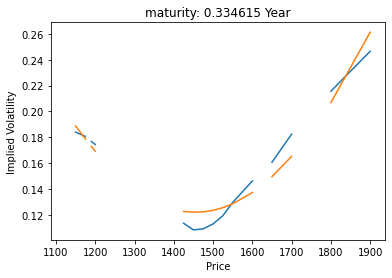

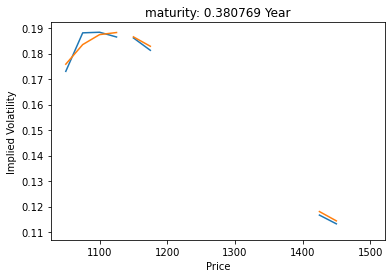

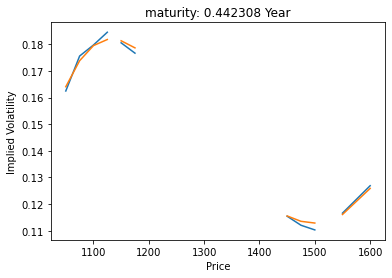

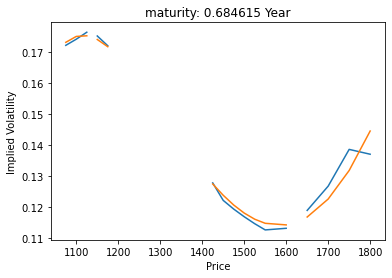

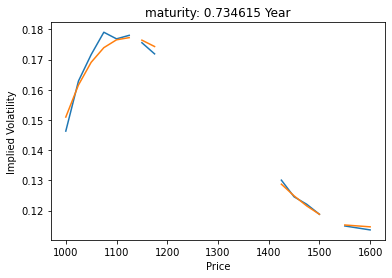

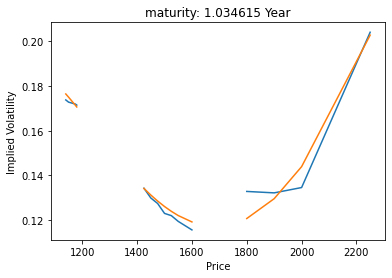

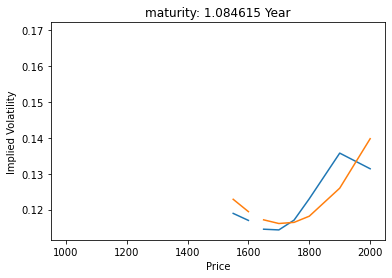

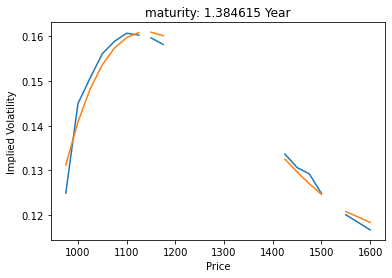

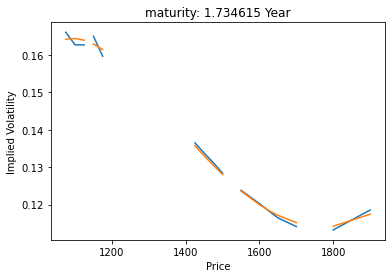

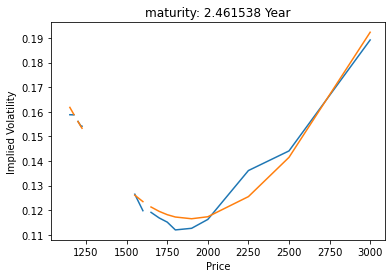

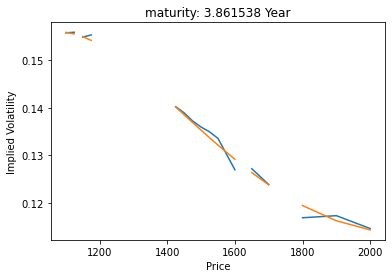

In [16]:
vol_surface = VLS.CubicSplineSurface(H,params)

t_times = list(set(data["T"]))
t_times.sort()
t_prices = list(set(data["Strike"]))
t_prices.sort()

test_res = vol_surface.check()
error = test_res["EstImpVol"] - test_res["ImpVol"]
print(error)
print("Max Error= {}, MSE = {}".format(abs(error).max(),(error**2).mean()))


test_res.drop_duplicates(inplace=True)
t_act = test_res.pivot(index = "Strike", columns = "T", values = "ImpVol")
t_est = test_res.pivot(index = "Strike", columns = "T", values = "EstImpVol")

for i in range(len(t_act.columns)):
    plt.figure(i)
    plot_check(t_act,t_est,i)



100%|██████████| 68/68 [00:00<00:00, 3145.65it/s]


100%|██████████| 15/15 [00:00<00:00, 198.10it/s]


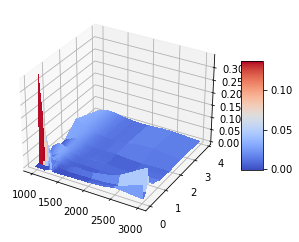

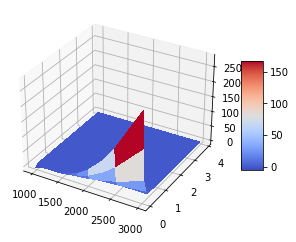

In [21]:
vol_surface.gen_local_vol_surface(t_prices,t_times)
VLS.plot_surface(t_prices,t_times, vol_surface.export_surface())
VLS.plot_surface(t_prices,t_times, vol_surface.export_surface(local_vol = False))


This is still within the range of feasiblilty, 

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 258/258 [00:01<00:00, 231.34it/s]


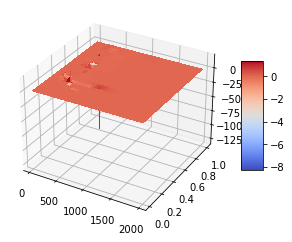

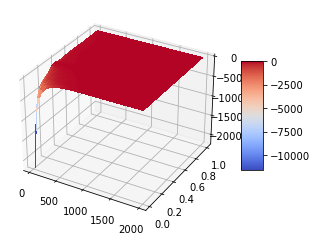

end


In [35]:
model_times  = np.arange(3/260,1+1/260,(1/260))
model_prices = np.arange(30,2000,30)

vol_surface.gen_local_vol_surface(model_prices,model_times,True)
local_surf = vol_surface.export_surface()
imp_surf = vol_surface.export_surface(False)
VLS.plot_surface(model_prices,model_times,local_surf)
VLS.plot_surface(model_prices,model_times,imp_surf)
print("end")

this is problematic, as it is now hugely negative, we don't expect the  volatility surface to be negative. It is also quite spiky. we are in effect hugly extrapolating form the dataset... what should we do with these outliers?